## Try to get all hydrogens around metal atoms about a conventional cell

In [2]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from collections import defaultdict

## Count the amount of a specie in a cell

In [4]:
pmg_struct = Structure.from_file("./CaH6.cif")
pmg_struct.composition.to_data_dict
# {
#   'reduced_cell_composition': Comp: Li2 Mg1 H16,
#   'unit_cell_composition': defaultdict(float,
#              {'Li': 16.0, 'Mg': 8.0, 'H': 128.0}),
#   'reduced_cell_formula': 'Li2MgH16',
#   'elements': ['Li', 'Mg', 'H'],
#   'nelements': 3
# }
pmg_struct.composition.num_atoms            # get amounts of all atoms
pmg_struct.composition.alphabetical_formula # 'H128 Li16 Mg8'
pmg_struct.composition.anonymized_formula   # 'AB2C16'
pmg_struct.composition.iupac_formula        # 'Li16 Mg8 H128'
pmg_struct.composition.chemical_system      # 'H-Li-Mg'
pmg_struct.composition.elements             # [Element Li, Element Mg, Element H]
pmg_struct.composition.special_formulas     #{
                                            #     'LiO': 'Li2O2',
                                            #     'NaO': 'Na2O2',
                                            #     'KO': 'K2O2',
                                            #     'HO': 'H2O2',
                                            #     'CsO': 'Cs2O2',
                                            #     'RbO': 'Rb2O2',
                                            #     'O': 'O2',
                                            #     'N': 'N2',
                                            #     'F': 'F2',
                                            #     'Cl': 'Cl2',
                                            #     'H': 'H2'
                                            # }
pmg_struct.composition.get_el_amt_dict()                    # defaultdict(float, {'Li': 16.0, 'Mg': 8.0, 'H': 128.0})
pmg_struct.composition.get_integer_formula_and_factor()     # ('Li2MgH16', 8.0)
pmg_struct.composition.get_reduced_composition_and_factor() # (Comp: Li2 Mg1 H16, 8)

pmg_struct.composition.chemical_system

e:\conda\envs\cage\lib\site-packages\pymatgen\io\cif.py:1229: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


'Ca-H'

## **一个小工具** 输入一个结构，输出其约化化学式，空间群对称性，文件名

In [ ]:
import sys
from pathlib import Path

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


struct = Structure.from_file("../test/POSCAR_YH9")
name = struct.composition.get_integer_formula_and_factor()[0]
spg = SpacegroupAnalyzer(struct)
num = spg.get_space_group_number()
spg_symbol = spg.get_space_group_symbol()
print(f"{num}-{spg_symbol}-{name}")
struct.lattice.matrix

## Voronoi模块的使用

In [ ]:
from pymatgen.core.structure import Structure
from pymatgen.analysis.chemenv.coordination_environments.structure_environments \
    import ChemicalEnvironments, StructureEnvironments, DetailedVoronoiContainer
from pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies \
    import SimplestChemenvStrategy

structure = Structure.from_file("./CaH6.cif")
vc = DetailedVoronoiContainer(structure)
# se = StructureEnvironments(voronoi_container)
# sc = SimplestChemenvStrategy()
# sc.get_site_neighbors(structure)

In [1]:
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis.local_env import NearNeighbors

s = Structure.from_file("./La2Y6H46_ContributedBy_Mayuan.vasp")
# graph = StructureGraph.with_local_env_strategy(structure, strategy=nn)

NameError: name 'Structure' is not defined

In [ ]:
from pymatgen.analysis.local_env import VoronoiNN

vnn = VoronoiNN()
all_vr = vnn.get_all_voronoi_polyhedra(structure)
all_vr

In [ ]:
from pymatgen.analysis.local_env import VoronoiNN

vnn = VoronoiNN()
all_vr = vnn.get_all_voronoi_polyhedra(structure)
all_vr

# 获得一个晶体晶胞的原子数

In [ ]:
from pymatgen.core.structure import Structure
pmg_struct = Structure.from_file("./CaH6.cif")
pmg_struct.density
pmg_struct.num_sites

# 替换元素

In [ ]:
from pymatgen.core.structure import Structure
from pymatgen.io.vasp import Poscar
# filenames1 = ["LaCeH8-200GPa-P4mmm", "LaCeH8-200GPa-Pmmn", "LaCeH18-200GPa-Amm2", 
#              "LaCeH20-200GPa-I41amd", "LaCeH20-200GPa-P-6m2", "LaCeH20-200GPa-P63mmc",
#             #  "LaCeH20-200GPa-R-3m",]
filenames2 = ["Y1Ce1H7-100GPa-Pmma", "YCeH5-100GPa-C2m", "YCeH8-100GPa-P4mmm", "YCeH18-200GPa-P-6m2", "YCeH20-400-P4mmm"]

for file in filenames2:
    s = Structure.from_file(file+".cif")
    s.replace_species({'Y':'Ce', 'Ce':'Sr'})
    formula=s.composition.reduced_formula.replace(' ', '')
    filename="f1-"+formula+'-'+'-'.join(file.split('-')[1:])
    print(filename)
    Poscar(s).write_file(filename=filename+".vasp")

# MP数据库使用

In [ ]:
#from pymatgen.ext.matproj import MPRester
from mp_api.client import MPRester

USER_API_KEY = "u6P9py7kaJapd48MgDvRRsFvB3Mrqqmz"

with MPRester(USER_API_KEY) as m:

    # Structure for material id
    structure = m.get_structure_by_material_id("mp-1234")

    # Dos for material id
    dos = m.get_dos_by_material_id("mp-1234")

    # Bandstructure for material id
    bandstructure = m.get_bandstructure_by_material_id("mp-1234")


In [ ]:
#from pymatgen.ext.matproj import MPRester

with MPRester(USER_API_KEY) as m:
    # results = m.summary.search("Ce*Al*", ['pretty_formula', 'energy'])
    structs = m.get_structures(chemsys_formula='Ce', final=True)



In [ ]:
import os

from pymatgen.io.vasp import Poscar
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
for s in structs:
    formula = s.formula.replace(' ', '')
    spgsymbol = SpacegroupAnalyzer(s).get_space_group_symbol().replace('/', '-')
    filename = formula+'-'+spgsymbol+'.vasp'
    print(filename)
    filepath = os.path.join('../test', filename)
    Poscar(s).write_file(filepath)

## 画出2_100, 2_010, 2_110的三个方向

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 定义三个向量
v1 = np.array([0.5, -0.8660254, 0])
v2 = np.array([-0.5, -0.8660254, 0])
v3 = np.array([1.0000000e+00, 2.0634445e-09, 0.0000000e+00])

v4 = np.array([-0.86602541,  0.5       ,  0.        ])
v5 = np.array([2.08240569e-09, 1.00000000e+00, 0.00000000e+00])
v6 = np.array([-0.8660254, -0.5      ,  0.       ])

# 将向量的 z 分量设为 0，得到它们在 xy 平面的投影
v1_xy = v1[:2]
v2_xy = v2[:2]
v3_xy = v3[:2]
v4_xy = v4[:2]
v5_xy = v5[:2]
v6_xy = v6[:2]
# 创建图形
plt.figure()

# 绘制向量的投影
plt.quiver(0, 0, v1_xy[0], v1_xy[1], angles='xy', scale_units='xy', scale=1, color='r', label='v1')
plt.quiver(0, 0, v2_xy[0], v2_xy[1], angles='xy', scale_units='xy', scale=1, color='g', label='v2')
plt.quiver(0, 0, v3_xy[0], v3_xy[1], angles='xy', scale_units='xy', scale=1, color='b', label='v3')
plt.quiver(0, 0, v4_xy[0], v4_xy[1], angles='xy', scale_units='xy', scale=1, color='cyan', label='v4')
plt.quiver(0, 0, v5_xy[0], v5_xy[1], angles='xy', scale_units='xy', scale=1, color='magenta', label='v5')
plt.quiver(0, 0, v6_xy[0], v6_xy[1], angles='xy', scale_units='xy', scale=1, color='yellow', label='v6')


# 设置坐标轴
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 显示图形
plt.grid()
plt.show()


## 符号运算与投影算符

In [ ]:
from collections import defaultdict
from typing import List, Sequence
from pprint import pprint

import numpy as np
from numpy import array

from pymatgen.symmetry.analyzer import SymmOp, SpacegroupAnalyzer
from pymatgen.core.structure import Structure, Molecule

def is_in_matrix(m:array, ms:List[array]) -> bool:
    """
    判断矩阵 m 是否在矩阵组成的列表 ms 中。

    Args:
        m: 要判断的矩阵。
        ms: 包含多个矩阵的列表。

    Returns:
        如果矩阵 m 存在于列表 ms 中，则返回 True，否则返回 False。
    """
    flag = True  # 初始化标志位为 True
    for _ in ms: # 遍历列表 ms 中的每个矩阵
        if np.allclose(m, _):  # 使用 np.allclose() 判断两个矩阵是否相似
            flag = True  # 如果找到相似的矩阵，则将标志位设为 True
            break  # 找到相似矩阵后退出循环
    else:  # 如果未找到相似的矩阵
        flag = False  # 将标志位设为 False
    return flag  # 返回标志位

def kill_duplicated_element(ms: List[np.ndarray]) -> List[np.ndarray]:
    """
    在一组 3*3 的矩阵中，找到重复的并删除。

    Args:
        ms: 包含多个 3*3 的矩阵的列表。

    Returns:
        删除重复矩阵后的新列表。
    """
    new_ms = []  # 初始化新列表
    for m in ms:  # 遍历原始列表中的每个矩阵
        if not new_ms:  # 如果新列表为空
            new_ms.append(m)  # 直接将当前矩阵添加到新列表中
        else:
            if not is_in_matrix(m=m, ms=new_ms):  # 如果当前矩阵不在新列表中
                new_ms.append(m)  # 将当前矩阵添加到新列表中
    return new_ms  # 返回新列表

def is_equal_for_cless(cl1: List[np.ndarray], cl2: List[np.ndarray]) -> bool:
    """
    判断两个类是否相同。

    Args:
        cl1: 第一个类，包含多个矩阵的列表。
        cl2: 第二个类，包含多个矩阵的列表。

    Returns:
        如果两个类相同（即包含相同的矩阵），返回 True，否则返回 False。
    """
    flag = True  # 初始化标志位为 True
    for m1 in cl1:  # 遍历第一个类中的每个矩阵
        if is_in_matrix(m1, cl2):  # 调用 is_in_matrix() 函数判断矩阵是否在第二个类中
            flag = True  # 如果找到相同的矩阵，则将标志位设为 True
            break  # 找到相同的矩阵后退出循环
    else:  # 如果第一个类中的所有矩阵都不在第二个类中
        flag = False  # 将标志位设为 False
    return flag  # 返回标志位

def is_in_clesses(cl1: List[np.ndarray], clesses: List[List[np.ndarray]]) -> bool:
    """
    判断一个类是否在一组类中。

    Args:
        cl1: 要判断的类，包含多个矩阵的列表。
        clesses: 包含多个类的列表，每个类都是包含多个矩阵的列表。

    Returns:
        如果要判断的类在一组类中，则返回 True，否则返回 False。
    """
    flag = True  # 初始化标志位为 True
    for cl2 in clesses:  # 遍历一组类中的每个类
        if is_equal_for_cless(cl1, cl2):  # 调用 is_equal_for_cless() 函数判断两个类是否相同
            flag = True  # 如果找到相同的类，则将标志位设为 True
            break  # 找到相同的类后退出循环
    else:  # 如果要判断的类不在一组类中
        flag = False  # 将标志位设为 False
    return flag  # 返回标志位

def kill_duplicated_clesses(clesses:List[List[np.ndarray]]) -> List[List[np.ndarray]]:
    """
    删除一组类中的重复类。

    Args:
        clesses: 包含多个类的列表，每个类都是包含多个矩阵的列表。

    Returns:
        删除重复类后的新列表。
    """
    new_clesses = []
    for cl in clesses: # cl此时是一个类，里面有很多个3*3的矩阵
        if not new_clesses:
            new_clesses.append(cl)
        else:
            if not is_in_clesses(cl1=cl, clesses=new_clesses):
                new_clesses.append(cl)
    return new_clesses

def find_cless_ops(cless:List[np.ndarray], spgops:List[SymmOp])-> List[np.ndarray]:
    """
    在一组对称操作中查找与给定类中的矩阵相匹配的操作。

    Args:
        cless: 给定类，包含多个矩阵的列表。
        spgops: 包含多个对称操作的列表，每个操作都是一个矩阵。

    Returns:
        匹配的对称操作列表opslist: List[SymmOp]。
    """
    opslist = []
    for rot in cless:
        for op in spgops:
            if np.allclose(op.rotation_matrix, rot):
                opslist.append(op)
                break
    return opslist

def get_rot_name(rot:np.ndarray)-> str: ### 这个函数废除了，不用了!!!, get_operation_type代替了它的功能
    """
    根据旋转矩阵推断对称操作的类型。

    Args:
        rot: 旋转矩阵。

    Returns:
        对称操作的类型。
    """
    typename = ''
    det = np.linalg.det(rot) 
    if det > 0: # det(rot)=1: rotation; 
        trc = np.trace(rot)
        theta = np.degrees(np.arccos((trc-1)/2))
        # print(trc); print(theta)
        if np.allclose(theta, 0.0):
            typename = "identity"
        else:
            typename = "rotation"+str(int(theta))
    else: # det(rot)=-1: rotoinversion
        trc = -np.trace(rot)
        theta = np.degrees(np.arccos((trc-1)/2))
        # print(trc); print(theta)
        if np.allclose(theta, 0.0):
            typename = "inversion"
        else:
            typename = "rotoinversion"+str(int(theta))
    return typename

def get_operation_type(Lattice, rotation):
    """
    Calculates the rotation axis and angle of the symmetry and if it 
    preserves handedness or not. 计算对称的旋转轴和角度，以及它是否保留手性。

    Returns
    -------
    tuple
        The first element is an array describing the rotation axis. The 
        second element describes the rotation angle. The third element is a 
        boolean, `True` if the symmetry preserves handedness 
        (determinant -1).
    """
    rotxyz = Lattice.T.dot(rotation).dot(np.linalg.inv(Lattice).T) #这里是为什么？？？？似乎是将旋转矩阵从晶格坐标转化为直角坐标
    # print ("rotation in real space:\n",rotxyz)
    E, V = np.linalg.eig(rotxyz)
    if not np.isclose(abs(E), 1).all():
        raise RuntimeError(
            "some eigenvalues of the rotation are not unitary")
            # 旋转的一些特征值是不酉的, 即, S·S-1 != E
    if E.prod() < 0:
        inversion = True
        E *= -1
    else:
        inversion = False
    idx = np.argsort(E.real)
    E = E[idx]
    V = V[:, idx]
    axis = V[:, 2].real
    if np.isclose(E[:2], 1).all():
        angle = 0
    elif np.isclose(E[:2], -1).all():
        angle = np.pi
    else:
        angle = np.angle(E[0])
        v = V[:, 0]
        s = np.real(np.linalg.det([v, v.conj(), axis]) / 1.j)
        if np.isclose(s, -1):
            angle = 2 * np.pi - angle
        elif not np.isclose(s, 1):
            raise RuntimeError("the sign of rotation should be +-1")
    return (axis, angle, inversion)

def get_cless_name(cless:List[SymmOp], lattice: np.ndarray)-> str:
    """
    根据一组共轭的对称操作推断类的共轭类名称。

    Args:
        cless: 一个共轭类列表包含多个对称操作的列表。

    Returns:
        共轭类的类型名称。
    """
    axis, angle, inversion = get_operation_type(struct.lattice.matrix, cless[0].rotation_matrix)
    axis_string  = list(map(str, np.round(axis, decimals=2)))
    angle_degree = str(np.round(np.degrees(angle), decimals=0))
    if inversion:
        name = angle_degree + '_' + "inversion" + '_axis__' + '_'.join(axis_string)
    else:
        name = angle_degree + '_axis__' + '_'.join(axis_string)
    
    return name

def classify_ops(spgops:List[SymmOp], lattice: np.ndarray) -> dict[str:List[SymmOp]]:
    """
    对称操作按照共轭类分类函数。

    Args:
        spgops: 包含多个对称操作的列表。

    Returns:
        按照共轭类分类后的对称操作字典，键是类的名称，值是包含多个对称操作的列表。
    """
    clesseslist: List[array] = []
    for idx, op in enumerate(spgops):
        # print(op.as_xyz_str())
        bm = [np.dot(np.dot(np.linalg.inv(x.rotation_matrix), op.rotation_matrix), x.rotation_matrix) for x in spgops]
        # print(bm)
        cless = kill_duplicated_element(bm) # 删除重复的矩阵，得到一个共轭类
        # print(cless)
        # for m in cless:
        #     print(detailed_info(m))
        # break
        clesseslist.append(cless) # 将类添加到类列表中

    clesseslist = kill_duplicated_clesses(clesseslist) # 删除重复的共轭类，得到一个共轭类
    # print((len(clesseslist)))
    clessesdict = defaultdict(list)
    for idx, cless in enumerate(clesseslist):
        ops:List[SymmOp] = find_cless_ops(cless, spgops=spgops)
        clessname:str = get_cless_name(ops, lattice)
        clessesdict[f'{clessname}'] = ops

    clessesdict:dict[List[SymmOp]] = dict(clessesdict)

    # if len(clesseslist) != len(clessesdict):
    #     raise ValueError('The size of clesseslist {} != the size of clessesdict {}'.format(len(clesseslist), len(clessesdict)))

    return clessesdict

def generate_mapping_matrix(mapping:dict[int:int], size:int)-> List[List[int]]:
    """
    通过给定的映射关系生成矩阵 A

    Args:
        mapping: 一个字典，表示映射关系，键为第一列的元素，值为第二列的元素

    Returns:
        矩阵 A
    """
    # 确定矩阵 A 的大小
    A = [[0] * size for _ in range(size)]
    # print(A)
    # 遍历映射关系，填充矩阵 A
    for idx, key in enumerate(mapping):
        value = mapping[key]
        A[idx][value] = 1
    # print(mapping)
    return A

def get_atoms_mapping_forstruct(op:SymmOp, struct:Structure)-> dict[int:int]:
    """
    根据对称操作将原子映射到新的原子位置。

    Args:
        op: 对称操作。
        struct: 原始晶体结构。

    Returns:
        映射字典，键是原始原子的索引，值是新原子的索引。
    """
    from pymatgen.core.sites import PeriodicSite
    
    Lattice = struct.lattice.matrix
    rotation = op.rotation_matrix
    mapping = {}
    for idx1, site1 in enumerate(struct):
        
        # 方式一
        newcoords = op.operate(site1.frac_coords)
        newsite = PeriodicSite(species=site1.species, coords=newcoords, to_unit_cell=True, lattice=struct.lattice, coords_are_cartesian=False)
        # print(site1.frac_coords, newsite.frac_coords)
        # s = np.array(([
        #     [1, -np.sin(np.pi/6), 0],
        #     [0,  np.cos(np.pi/6), 0],
        #     [0,  0,  1],
        # ]))
        # s_1 = np.linalg.inv(s)
        # new_rotation_matrix = np.dot(np.dot(s_1, op.rotation_matrix), s)
        # new_rotation_matrix = np.dot(np.dot(s, op.rotation_matrix), s_1)
         # pprint(op.rotation_matrix)
        # pprint(new_rotation_matrix)
        
        # 方式二
        # rotxyz = Lattice.T.dot(rotation).dot(np.linalg.inv(Lattice).T) 
        # newcoords = np.dot(rotxyz, site1.coords)
        # newsite = PeriodicSite(species=site1.species, coords=newcoords, to_unit_cell=True, lattice=struct.lattice, coords_are_cartesian=True)
        # print(site1.frac_coords, newsite.frac_coords)

        for idx2, site2 in enumerate(struct):
            # print("判断 new-{} {} 是否与 {} {} 等价".format(idx1, newsite.frac_coords, idx2, site2.frac_coords))
            # print("{} {}-> {} {}".format(idx1, site1, idx2, newsite))
            # input()
            # print(np.allclose(newsite.frac_coords, site2.frac_coords, rtol=1e-3))
            if np.allclose(newsite.frac_coords, site2.frac_coords, rtol=1e-3):  # pymatgen 源代码检查了元素是否相等，坐标是否相等，性质是否相等 self.species == other.species and np.allclose(self.coords, other.coords, atol=Site.position_atol) and self.properties == other.properties
                mapping[idx1] = idx2
                break
        else:
            print("没有找到经过对称操作 {} 作用后，与{} {}等价的原子".format(op, idx1, site1.frac_coords))
        # print(mapping)
    # print(mapping)
    return mapping

def get_conjugate_character(ops:List[SymmOp], struct:Structure)-> int:
    """
    获取给定共轭类的特征标

    Args:
        ops: 共轭类，包含多个对称操作的列表。
        struct: 结构。

    Returns:
        共轭类的特征标
    """
    trcs = []
    # print(ops)
    for op in ops:
        # print(op)
        mapping = get_atoms_mapping_forstruct(op, struct)
        # pprint(mapping)
        A = generate_mapping_matrix(mapping, size=len(struct))
        trc = np.trace(A)
        trcs.append(trc)
        # pprint(A)
    if len(set(trcs)) == 1:
        return trc, A
    else:
        raise ValueError("The value of traces in the same conjugate class is different")

def get_atomic_character(new_spgops:dict[str:SymmOp], struct:Structure)-> tuple[dict[str:int], List[List[int]]]: 
    """
    获取原子的特征标

    Args:
        new_spgops: 包含所有分好共轭类的字典，键是共轭类的名称，值是相应的对称操作列表。
        struct: 结构。

    Returns:
        包含原子特征的字典，键是操作类的名称，值是对应的特征值。
    """
    atomic_charater = {}
    atomic_mapmatrix= {}
    for name, ops in new_spgops.items():
        # print(name)
        trc, matrix = get_conjugate_character(ops, struct)
        # print(trc, matrix)
        # input()
        atomic_charater[name] = trc
        atomic_mapmatrix[name] = matrix
    return (atomic_charater, atomic_mapmatrix)

In [ ]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SymmetrizedStructure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

struct = Structure.from_file('../test/POSCAR_CaH6')
partial_struct = Structure.from_file("../test/POSCAR_CaH6_partical")
# spgops = spg.get_space_group_operations()
spg = SpacegroupAnalyzer(struct)
spgops = spg.get_point_group_operations()
new_spgops = classify_ops(spgops, partial_struct.lattice)
conjugate_charater, atomic_mapmatrix = get_atomic_character(new_spgops, partial_struct)

# names = ['identity_1','rotation90_6', 'rotation180_3', 'rotation120_8', 'rotation180_6',  'inversion_1', 'rotoinversion90_6', 'rotoinversion180_3',  'rotoinversion120_8', 'rotoinversion180_6', ]
names = [
    '0.0_axis__0.0_0.99_0.13',
    '90.0_axis__0.0_0.0_1.0',
    '180.0_axis__0.0_0.0_1.0',
    '120.0_axis__0.58_0.58_0.58',
    '180.0_axis__-0.71_0.71_0.0',
    '0.0_inversion_axis__0.0_0.99_-0.13',
    '450.0_inversion_axis__0.0_0.0_1.0',
    '180.0_inversion_axis__0.0_0.0_1.0',
    '-120.0_inversion_axis__-0.58_-0.58_-0.58',
    '180.0_inversion_axis__0.71_-0.71_-0.0',
            ]
# mult1  = np.array([1,6,3,8,6, 1,6,3,8,6])
mult2  = np.array([len(new_spgops[name]) for name in names])
print(mult2)
red_reps = np.array([conjugate_charater[name] for name in names])


irred_repss={
    'A1g' : np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
    'A1u' : np.array([1, 1, 1, 1, 1,-1,-1,-1,-1,-1]),
    'A2g' : np.array([1,-1, 1, 1,-1, 1,-1, 1, 1,-1]),
    'A2u' : np.array([1,-1, 1, 1,-1,-1, 1,-1,-1, 1]),
    'Eg'  : np.array([2, 0, 2,-1, 0, 2, 0, 2,-1, 0]),
    'Eu'  : np.array([2, 0, 2,-1, 0,-2, 0,-2, 1, 0]),
    'T2u' : np.array([3,-1,-1, 0, 1,-3, 1, 1, 0,-1]),
    'T2g' : np.array([3,-1,-1, 0, 1, 3,-1,-1, 0, 1]),
    'T1u' : np.array([3, 1,-1, 0,-1,-3,-1, 1, 0, 1]),
    'T1g' : np.array([3, 1,-1, 0,-1, 3, 1,-1, 0,-1]),
    }
for irred_reps_name, irred_reps_character in irred_repss.items():
    x=np.sum(mult2*irred_reps_character*(np.array(red_reps)))/np.sum(mult2)
    if x != 0:
        print(irred_reps_name)

# 水分子投影算符

In [ ]:
from ase.build import molecule

atoms = molecule('H2O', vacuum=2)
print(atoms.get_cell().get_bravais_lattice())
print(atoms.get_cell().angles())
for a in atoms:
    print(a)


In [ ]:
from collections import defaultdict
from typing import List, Sequence
from pprint import pprint

import numpy as np
from numpy import array

from pymatgen.symmetry.analyzer import SymmOp, SpacegroupAnalyzer
from pymatgen.core.structure import Structure, Molecule

def is_in_matrix(m:array, ms:List[array]) -> bool:
    """
    判断矩阵 m 是否在矩阵组成的列表 ms 中。

    Args:
        m: 要判断的矩阵。
        ms: 包含多个矩阵的列表。

    Returns:
        如果矩阵 m 存在于列表 ms 中，则返回 True，否则返回 False。
    """
    flag = True  # 初始化标志位为 True
    for _ in ms: # 遍历列表 ms 中的每个矩阵
        if np.allclose(m, _):  # 使用 np.allclose() 判断两个矩阵是否相似
            flag = True  # 如果找到相似的矩阵，则将标志位设为 True
            break  # 找到相似矩阵后退出循环
    else:  # 如果未找到相似的矩阵
        flag = False  # 将标志位设为 False
    return flag  # 返回标志位

def kill_duplicated_element(ms: List[np.ndarray]) -> List[np.ndarray]:
    """
    在一组 3*3 的矩阵中，找到重复的并删除。

    Args:
        ms: 包含多个 3*3 的矩阵的列表。

    Returns:
        删除重复矩阵后的新列表。
    """
    new_ms = []  # 初始化新列表
    for m in ms:  # 遍历原始列表中的每个矩阵
        if not new_ms:  # 如果新列表为空
            new_ms.append(m)  # 直接将当前矩阵添加到新列表中
        else:
            if not is_in_matrix(m=m, ms=new_ms):  # 如果当前矩阵不在新列表中
                new_ms.append(m)  # 将当前矩阵添加到新列表中
    return new_ms  # 返回新列表

def is_equal_for_cless(cl1: List[np.ndarray], cl2: List[np.ndarray]) -> bool:
    """
    判断两个类是否相同。

    Args:
        cl1: 第一个类，包含多个矩阵的列表。
        cl2: 第二个类，包含多个矩阵的列表。

    Returns:
        如果两个类相同（即包含相同的矩阵），返回 True，否则返回 False。
    """
    flag = True  # 初始化标志位为 True
    for m1 in cl1:  # 遍历第一个类中的每个矩阵
        if is_in_matrix(m1, cl2):  # 调用 is_in_matrix() 函数判断矩阵是否在第二个类中
            flag = True  # 如果找到相同的矩阵，则将标志位设为 True
            break  # 找到相同的矩阵后退出循环
    else:  # 如果第一个类中的所有矩阵都不在第二个类中
        flag = False  # 将标志位设为 False
    return flag  # 返回标志位

def is_in_clesses(cl1: List[np.ndarray], clesses: List[List[np.ndarray]]) -> bool:
    """
    判断一个类是否在一组类中。

    Args:
        cl1: 要判断的类，包含多个矩阵的列表。
        clesses: 包含多个类的列表，每个类都是包含多个矩阵的列表。

    Returns:
        如果要判断的类在一组类中，则返回 True，否则返回 False。
    """
    flag = True  # 初始化标志位为 True
    for cl2 in clesses:  # 遍历一组类中的每个类
        if is_equal_for_cless(cl1, cl2):  # 调用 is_equal_for_cless() 函数判断两个类是否相同
            flag = True  # 如果找到相同的类，则将标志位设为 True
            break  # 找到相同的类后退出循环
    else:  # 如果要判断的类不在一组类中
        flag = False  # 将标志位设为 False
    return flag  # 返回标志位

def kill_duplicated_clesses(clesses:List[List[np.ndarray]]) -> List[List[np.ndarray]]:
    """
    删除一组类中的重复类。

    Args:
        clesses: 包含多个类的列表，每个类都是包含多个矩阵的列表。

    Returns:
        删除重复类后的新列表。
    """
    new_clesses = []
    for cl in clesses: # cl此时是一个类，里面有很多个3*3的矩阵
        if not new_clesses:
            new_clesses.append(cl)
        else:
            if not is_in_clesses(cl1=cl, clesses=new_clesses):
                new_clesses.append(cl)
    return new_clesses

def find_cless_ops(cless:List[np.ndarray], spgops:List[SymmOp])-> List[np.ndarray]:
    """
    在一组对称操作中查找与给定类中的矩阵相匹配的操作。

    Args:
        cless: 给定类，包含多个矩阵的列表。
        spgops: 包含多个对称操作的列表，每个操作都是一个矩阵。

    Returns:
        匹配的对称操作列表opslist: List[SymmOp]。
    """
    opslist = []
    for rot in cless:
        for op in spgops:
            if np.allclose(op.rotation_matrix, rot):
                opslist.append(op)
                break
    return opslist

def get_rot_name(rot:np.ndarray)-> str: ### 这个函数废除了，不用了!!!, get_operation_type代替了它的功能
    """
    根据旋转矩阵推断对称操作的类型。

    Args:
        rot: 旋转矩阵。

    Returns:
        对称操作的类型。
    """
    typename = ''
    det = np.linalg.det(rot) 
    if det > 0: # det(rot)=1: rotation; 
        trc = np.trace(rot)
        theta = np.degrees(np.arccos((trc-1)/2))
        # print(trc); print(theta)
        if np.allclose(theta, 0.0):
            typename = "identity"
        else:
            typename = "rotation"+str(int(theta))
    else: # det(rot)=-1: rotoinversion
        trc = -np.trace(rot)
        theta = np.degrees(np.arccos((trc-1)/2))
        # print(trc); print(theta)
        if np.allclose(theta, 0.0):
            typename = "inversion"
        else:
            typename = "rotoinversion"+str(int(theta))
    return typename

def get_operation_type(rotation):
    """
    Calculates the rotation axis and angle of the symmetry and if it 
    preserves handedness or not. 计算对称的旋转轴和角度，以及它是否保留手性。

    Returns
    -------
    tuple
        The first element is an array describing the rotation axis. The 
        second element describes the rotation angle. The third element is a 
        boolean, `True` if the symmetry preserves handedness 
        (determinant -1).
    """
    # rotxyz = Lattice.T.dot(rotation).dot(np.linalg.inv(Lattice).T) #这里是为什么？？？？似乎是将旋转矩阵从晶格坐标转化为直角坐标
    # print ("rotation in real space:\n",rotxyz)
    E, V = np.linalg.eig(rotation)
    if not np.isclose(abs(E), 1).all():
        raise RuntimeError(
            "some eigenvalues of the rotation are not unitary")
            # 旋转的一些特征值是不酉的, 即, S·S-1 != E
    if E.prod() < 0:
        inversion = True
        E *= -1
    else:
        inversion = False
    idx = np.argsort(E.real)
    E = E[idx]
    V = V[:, idx]
    axis = V[:, 2].real
    if np.isclose(E[:2], 1).all():
        angle = 0
    elif np.isclose(E[:2], -1).all():
        angle = np.pi
    else:
        angle = np.angle(E[0])
        v = V[:, 0]
        s = np.real(np.linalg.det([v, v.conj(), axis]) / 1.j)
        if np.isclose(s, -1):
            angle = 2 * np.pi - angle
        elif not np.isclose(s, 1):
            raise RuntimeError("the sign of rotation should be +-1")
    return (axis, angle, inversion)

def get_cless_name(cless:List[SymmOp])-> str:
    """
    根据一组共轭的对称操作推断类的共轭类名称。

    Args:
        cless: 一个共轭类列表包含多个对称操作的列表。

    Returns:
        共轭类的类型名称。
    """
    axis, angle, inversion = get_operation_type(cless[0].rotation_matrix)
    axis_string  = list(map(str, np.round(axis, decimals=2)))
    angle_degree = str(np.round(np.degrees(angle), decimals=0))
    if inversion:
        name = angle_degree + '_' + "inversion" + '_axis__' + '_'.join(axis_string)
    else:
        name = angle_degree + '_axis__' + '_'.join(axis_string)
    
    return name

def classify_ops(spgops:List[SymmOp]) -> dict[str:List[SymmOp]]:
    """
    对称操作按照共轭类分类函数。

    Args:
        spgops: 包含多个对称操作的列表。

    Returns:
        按照共轭类分类后的对称操作字典，键是类的名称，值是包含多个对称操作的列表。
    """
    clesseslist: List[array] = []
    for idx, op in enumerate(spgops):
        # print(op.as_xyz_str())
        bm = [np.dot(np.dot(np.linalg.inv(x.rotation_matrix), op.rotation_matrix), x.rotation_matrix) for x in spgops]
        # print(bm)
        cless = kill_duplicated_element(bm) # 删除重复的矩阵，得到一个共轭类
        # print(cless)
        # for m in cless:
        #     print(detailed_info(m))
        # break
        clesseslist.append(cless) # 将类添加到类列表中

    clesseslist = kill_duplicated_clesses(clesseslist) # 删除重复的共轭类，得到一个共轭类
    # print((len(clesseslist)))
    clessesdict = defaultdict(list)
    for idx, cless in enumerate(clesseslist):
        ops:List[SymmOp] = find_cless_ops(cless, spgops=spgops)
        clessname:str = get_cless_name(ops)
        clessesdict[f'{clessname}'] = ops

    clessesdict:dict[List[SymmOp]] = dict(clessesdict)

    # if len(clesseslist) != len(clessesdict):
    #     raise ValueError('The size of clesseslist {} != the size of clessesdict {}'.format(len(clesseslist), len(clessesdict)))

    return clessesdict

def generate_mapping_matrix(mapping:dict[int:int], size:int)-> List[List[int]]:
    """
    通过给定的映射关系生成矩阵 A

    Args:
        mapping: 一个字典，表示映射关系，键为第一列的元素，值为第二列的元素

    Returns:
        矩阵 A
    """
    # 确定矩阵 A 的大小
    A = [[0] * size for _ in range(size)]
    # print(A)
    # 遍历映射关系，填充矩阵 A
    for idx, key in enumerate(mapping):
        value = mapping[key]
        A[idx][value] = 1
    # print(mapping)
    return A

def get_atoms_mapping_formol(op:SymmOp, mol:Molecule)-> dict[int:int]:
    """
    根据对称操作将原子映射到新的原子位置。

    Args:
        op: 对称操作。
        struct: 原始晶体结构。

    Returns:
        映射字典，键是原始原子的索引，值是新原子的索引。
    """
    from pymatgen.core.sites import Site
    
    # Lattice = struct.lattice.matrix
    rotation = op.rotation_matrix
    mapping = {}
    for idx1, site1 in enumerate(mol):
        
        # 方式一
        # print(op)
        newcoords = op.operate(site1.coords)
        newsite = Site(species=site1.species, coords=newcoords)
        # print(site1.coords, newsite.coords)
        # s = np.array(([
        #     [1, -np.sin(np.pi/6), 0],
        #     [0,  np.cos(np.pi/6), 0],
        #     [0,  0,  1],
        # ]))
        # s_1 = np.linalg.inv(s)
        # new_rotation_matrix = np.dot(np.dot(s_1, op.rotation_matrix), s)
        # new_rotation_matrix = np.dot(np.dot(s, op.rotation_matrix), s_1)
         # pprint(op.rotation_matrix)
        # pprint(new_rotation_matrix)
        
        # 方式二
        # rotxyz = Lattice.T.dot(rotation).dot(np.linalg.inv(Lattice).T) 
        # newcoords = np.dot(rotxyz, site1.coords)
        # newsite = PeriodicSite(species=site1.species, coords=newcoords, to_unit_cell=True, lattice=struct.lattice, coords_are_cartesian=True)
        # print(site1.coords, newsite.coords)

        for idx2, site2 in enumerate(mol):
            # print("判断 new-{} {} 是否与 {} {} 等价".format(idx1, newsite.coords, idx2, site2.coords))
            # print("{} {}-> {} {}".format(idx1, site1, idx2, newsite))
            # input()
            # print(np.allclose(newsite.coords, site2.coords, rtol=1e-3))
            if np.allclose(newsite.coords, site2.coords, rtol=1e-3):  # pymatgen 源代码检查了元素是否相等，坐标是否相等，性质是否相等 self.species == other.species and np.allclose(self.coords, other.coords, atol=Site.position_atol) and self.properties == other.properties
                mapping[idx1] = idx2
                break
        else:
            print("没有找到经过对称操作 {} 作用后，与{} {}等价的原子".format(op, idx1, site1.coords))
        # print(mapping)
    # print(mapping)
    return mapping

def get_conjugate_character(ops:List[SymmOp], struct:Molecule)-> int:
    """
    获取给定共轭类的特征标

    Args:
        ops: 共轭类，包含多个对称操作的列表。
        struct: 结构。

    Returns:
        共轭类的特征标
    """
    trcs = []
    # print(ops)
    for op in ops:
        # print(op)
        mapping = get_atoms_mapping_formol(op, struct)
        # pprint(mapping)
        A = generate_mapping_matrix(mapping, size=len(struct))
        trc = np.trace(A)
        trcs.append(trc)
        # pprint(A)
    if len(set(trcs)) == 1:
        return trc, A
    else:
        raise ValueError("The value of traces in the same conjugate class is different")

def get_atomic_character(new_spgops:dict[str:SymmOp], struct:Molecule)-> tuple[dict[str:int], List[List[int]]]: 
    """
    获取原子的特征标

    Args:
        new_spgops: 包含所有分好共轭类的字典，键是共轭类的名称，值是相应的对称操作列表。
        struct: 结构。

    Returns:
        包含原子特征的字典，键是操作类的名称，值是对应的特征值。
    """
    atomic_charater = {}
    atomic_mapmatrix= {}
    for name, ops in new_spgops.items():
        # print(name)
        trc, matrix = get_conjugate_character(ops, struct)
        # print(trc, matrix)
        # input()
        atomic_charater[name] = trc
        atomic_mapmatrix[name] = matrix
    return (atomic_charater, atomic_mapmatrix)

In [ ]:
from pymatgen.core.structure import Structure, Molecule
from pymatgen.symmetry.analyzer import SymmetrizedStructure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
coords=np.array([[2.0, 3.5264780000000004, 1.9999999999999998], [2.0, 2.0000000000000004, 1.9999999999999998], [2.0, 2.7632390000000004, 2.5963089999999998]])
coords = coords - np.array([2.0, 2.7632390000000004, 2.5963089999999998])
mol = Molecule(species=["H", "H", "O"], coords=coords)
print(mol)
pg = PointGroupAnalyzer(mol)
print(pg.sch_symbol)
pgops = pg.get_symmetry_operations()
new_pgops = classify_ops(pgops)
# print(new_pgops)

conjugate_charater, atomic_mapmatrix = get_atomic_character(new_pgops, mol)
names = [
    '0.0_axis__0.0_0.0_1.0',
    '180.0_axis__0.0_0.0_1.0',
    '180.0_inversion_axis__0.0_1.0_0.0',
    '180.0_inversion_axis__1.0_0.0_0.0',
]
mult  = np.array([len(new_pgops[name]) for name in names])
print(mult)
red_reps = np.array([conjugate_charater[name] for name in names])
print(red_reps)

irred_repss={
    'A1' : np.array([1, 1, 1, 1,]),
    'A2' : np.array([1, 1,-1,-1,]),
    'B1' : np.array([1,-1, 1,-1,]),
    'B2' : np.array([1,-1,-1, 1,]),
    }
for irred_reps_name, irred_reps_character in irred_repss.items():
    x=np.sum(mult*irred_reps_character*(np.array(red_reps)))/np.sum(mult)
    if x != 0:
        print(irred_reps_name)

In [ ]:
import sympy as sp
import mpmath as mpm

sp.init_session()

x, y, z, r = sp.symbols('x y z r')
r2 = x**2+y**2+z**2
r  = sp.sqrt(r2)

# hydrgon1_s = sp.Piecewise((1, (x, y, z) == (0.000000,  0.763239, -0.596309)), (0, True))
# hydrgon2_s = sp.Piecewise((1, (x, y, z) == (0.000000, -0.763239, -0.596309)), (0, True))
hydrgon1_s = 0*x+0*y+0*z+1
hydrgon2_s = 0*x+0*y+0*z+1

Oxygen_px = x/r
Oxygen_py = y/r
Oxygen_pz = z/r


d3z2_r2 = (3*z**2-r2)/r2
dx2_y2 = (x**2-y**2)/r2
dzx = z*x/r2
dxy = x*y/r2
dyz = y*z/r2


In [ ]:

for name in names:
    op  = new_pgops[name][0]
    res = sp.Matrix(op.operate_multi([[1,0,0],[0,1,0],[0,0,1]])) # x,y,z以矩阵形式存储
    xyz = sp.Matrix([sp.symbols('x y z')]) # 获得x',y',z'
    x_,y_,z_  = xyz.multiply(res)
    res_exp = Oxygen_px.subs([(x, x_), (y, y_), (z, z_)])
    print(f"name = {name} \n x = {x_} y = {y_} z = {z_}")
    print(res_exp)
    print()

In [ ]:
import sympy as sp

# 定义符号变量
x, y, z = sp.symbols('x y z')

# 定义分段函数
f = sp.Piecewise((1, (x, y, z) == (0.000000, 0.763239, -0.596309)), (0, True))

# 测试分段函数
result = f.subs({x: 0.000000, y: 0.763239, z: -0.596309})
print("在 x=0.000000, y=0.763239, z=-0.596309 时，函数值为:", result)

# 测试其他位置
result = f.subs({x: 1, y: 2, z: 3})
print("在其他位置时，函数值为:", result)


# Pymatgen绘制能带和DOS

In [99]:
import sys
import os
import numpy as np

import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection
# from matplotlib.gridspec import GridSpec


from pymatgen.io.vasp.outputs import Vasprun
# from pymatgen.electronic_structure.core import Spin, OrbitalType
# from pymatgen.electronic_structure import plotter
from pymatgen.electronic_structure.plotter import BSDOSPlotter, BSPlotter, BSPlotterProjected, DosPlotter

eledosfile = "../test/dos_vasprun.xml"# such as, eledos/vasprun.xml
ebandfile = "../test/band_vasprun.xml" # such as, eband/vasprun.xml
ebandkpoints = "../test/KPOINTS" # such as, eband/KPOINTS

dosrun = Vasprun(eledosfile, parse_potcar_file=False)
dos_data = dosrun.complete_dos

# bands
bs_run = Vasprun(ebandfile, parse_projected_eigen=True, parse_potcar_file=False)
bs_data = bs_run.get_band_structure(
                                kpoints_filename=ebandkpoints,
                                # efermi=dosrun.efermi,
                                line_mode=True,
                                )

In [ ]:
# 能带图加上态密度
# 无投影的能带和态密度
plot1 = BSDOSPlotter(bs_projection = None, dos_projection= None)
plot1.get_plot(bs=bs_data,dos=dos_data)
plt.savefig('1.band_dos.png',dpi=300)
plt.show() 

In [ ]:
# 将能带和态密度投影到元素
plot2 = BSDOSPlotter(bs_projection = 'elements', dos_projection= 'elements')
plot2.get_plot(bs=bs_data,dos=dos_data)
plt.savefig('2.band投影元素_dos投影元素.png',dpi=300)
plt.show() 


In [ ]:
# 将能带投影到元素，态密度投影到轨道
plot3 = BSDOSPlotter(bs_projection = 'elements', dos_projection='orbitals')
plot3.get_plot(bs=bs_data,dos=dos_data)
plt.savefig('3.band投影元素_dos投影轨道.png',dpi=300)
plt.show() 


In [ ]:
# 只画能带图
# 原始的能带
bsplot=BSPlotter(bs=bs_data)
bsplot.get_plot()
# bsplot.save_plot("4.band.png", img_format='png')
bsplot.save_plot("4.band.png")

In [ ]:
# 将能带投影到元素
bsplotproj=BSPlotterProjected(bs=bs_data)
plt=bsplotproj.get_elt_projected_plots()

#plt = bsplotproj.get_plt_projected_plots_color()
# bsplotproj.save_plot("5.band投影元素.png")
plt.savefig("5.band投影元素.png")

In [ ]:
# 将能带投影到不同元素的不同轨道，即角量子数
# bsplotproj=BSPlotterProjected(bs=bs_data)
plt=bsplotproj.get_projected_plots_dots(
    dictio={'La':['s', 'p', 'd', 'f'],
            # 'Ce' :['s', 'p', 'd'],
            # 'Be':['s', 'p'],
            'H' :['s'],})
# bsplotproj.save_plot("6.band投影指定元素的指定角量子轨道.png")
plt.savefig("6.band投影指定元素的指定角量子轨道.png")

In [ ]:
# 将能带投影到不同元素的不同轨道的分量，即磁量子数
# bsplotproj=BSPlotterProjected(bs=bs_data)
plt=bsplotproj.get_projected_plots_dots_patom_pmorb(
    dictio={#'Be':['px', 'py', 'pz'],
            'La':['px', 'py', 'pz', 'dxy', 'dyz', 'dz2', 'dxz', 'dx2']},
    dictpa={#'Be':[3, 4],
            'La':[1]})
# bsplotproj.save_plot("7.band投影指定元素的指定磁量子轨道和指定原子轨道.png")
plt.savefig("7.band投影指定元素的指定磁量子轨道和指定原子轨道.png")

In [ ]:
# sum_atoms可以画同种原子的总投影，sum_morbs可以画同种原子不同轨道的总投影
plt=bsplotproj.get_projected_plots_dots_patom_pmorb(
    dictio={'La':['px', 'py', 'pz', 'dxy', 'dyz', 'dz2', 'dxz', 'dx2'],
            #'Be':['px', 'py', 'pz'] 
            },
    dictpa={
        #'Be':[3, 4],
            'La':[1]},
    sum_morbs={'La':['px', 'py', 'pz', 'dxy', 'dyz', 'dz2', 'dxz', 'dx2'],
               #'Be':['px', 'py', 'pz']
               })
# bsplotproj.save_plot("8.band投影同种原子的轨道.png")
plt.savefig("8.band投影同种原子的轨道.png")

In [ ]:
# 只画态密度
# 总态密度: stack表示是否填充颜色，sigma表示是否展宽
dostotal=DosPlotter(stack=False, sigma=0.5)
dostotal.add_dos('total dos', dos=dos_data)
dostotal.save_plot('9.dos总态密度.png')

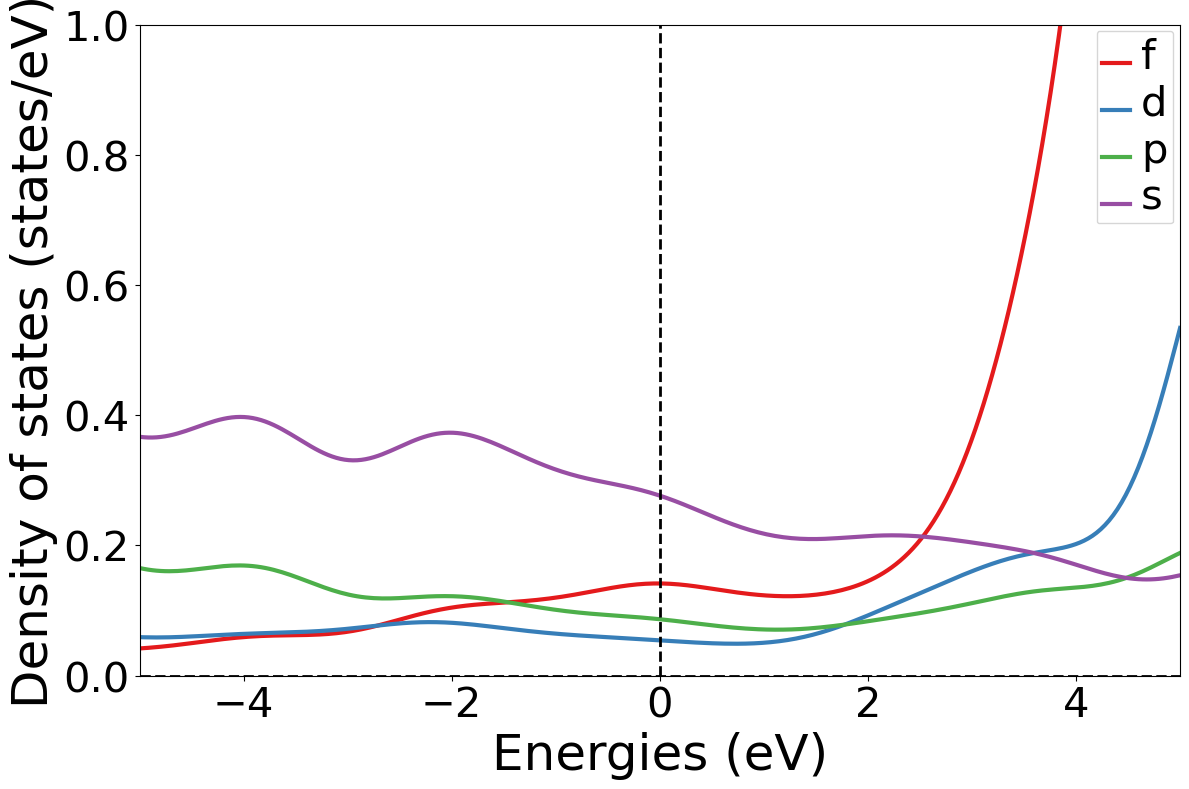

In [100]:

# 投影态密度到轨道
dostotal=DosPlotter(stack=False, sigma=0.5)
# dostotal.add_dos('project spd orbits', dos=dos_data)
dostotal.add_dos_dict(dos_data.get_spd_dos())
dostotal.save_plot('10.dos投影态密度到轨道.png', xlim=[-5, 5], ylim=[0,1])# img_format=u'png')

In [ ]:
# 投影态密度到元素
dostotal=DosPlotter(stack=False, sigma=0.5)
dostotal.add_dos('project element pdos', dos=dos_data)
dostotal.add_dos_dict(dos_data.get_element_dos())
dostotal.save_plot('11.dos投影态密度到元素.png',)# img_format=u'png')

In [1]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

s = Structure.from_file("../test/POSCAR_LaH10")
spg = SpacegroupAnalyzer(s)
for idx, op in enumerate(spg.get_space_group_operations()):
    rot = op.rotation_matrix
    t = op.translation_vector
    # 格式化旋转矩阵部分
    rot_str = ', '.join(['{' + ', '.join(map(str, row)) + '}' for row in rot])
    # 格式化平移向量部分
    t_str = '{' + ', '.join(map(str, t)) + '}'

    plus_str = 'T' + str(idx+1) + '=' '{' + '{' + rot_str + '}' ', ' + t_str + '}' + ';'
    print(plus_str)
    # 打印结果
    # print(f"{{{rot_str}}, {{{t_str}}}}")

# 创建一个包含从 T1 到 T48 的变量名列表
Tlist = [f"T{i}" for i in range(1, 49)]

# 打印列表
print("Tlist = {" + ", ".join(Tlist) + "};")


T1={{{1.0, 0.0, 0.0}, {0.0, 1.0, 0.0}, {0.0, 0.0, 1.0}}, {0.0, 0.0, 0.0}};
T2={{{-1.0, 0.0, 0.0}, {0.0, -1.0, 0.0}, {0.0, 0.0, -1.0}}, {0.0, 0.0, 0.0}};
T3={{{1.0, 1.0, 1.0}, {0.0, 0.0, -1.0}, {-1.0, 0.0, 0.0}}, {0.0, 0.0, 0.0}};
T4={{{-1.0, -1.0, -1.0}, {0.0, 0.0, 1.0}, {1.0, 0.0, 0.0}}, {0.0, 0.0, 0.0}};
T5={{{0.0, 1.0, 0.0}, {1.0, 0.0, 0.0}, {-1.0, -1.0, -1.0}}, {0.0, 0.0, 0.0}};
T6={{{0.0, -1.0, 0.0}, {-1.0, 0.0, 0.0}, {1.0, 1.0, 1.0}}, {0.0, 0.0, 0.0}};
T7={{{0.0, 0.0, -1.0}, {1.0, 1.0, 1.0}, {0.0, -1.0, 0.0}}, {0.0, 0.0, 0.0}};
T8={{{0.0, 0.0, 1.0}, {-1.0, -1.0, -1.0}, {0.0, 1.0, 0.0}}, {0.0, 0.0, 0.0}};
T9={{{-1.0, -1.0, -1.0}, {0.0, 0.0, 1.0}, {0.0, 1.0, 0.0}}, {0.0, 0.0, 0.0}};
T10={{{1.0, 1.0, 1.0}, {0.0, 0.0, -1.0}, {0.0, -1.0, 0.0}}, {0.0, 0.0, 0.0}};
T11={{{0.0, -1.0, 0.0}, {-1.0, 0.0, 0.0}, {0.0, 0.0, -1.0}}, {0.0, 0.0, 0.0}};
T12={{{0.0, 1.0, 0.0}, {1.0, 0.0, 0.0}, {0.0, 0.0, 1.0}}, {0.0, 0.0, 0.0}};
T13={{{0.0, 0.0, 1.0}, {-1.0, -1.0, -1.0}, {1.0, 0.0, 0.0}}, {0.0, 0.0,

In [9]:
from pymatgen.core.structure import Molecule
from pymatgen.symmetry.analyzer import PointGroupAnalyzer

# 定义甲烷分子的原子坐标
species = ["C", "H", "H", "H", "H"]
coords = [
    [0.0000, 0.0000, 0.0000],   # Carbon
    [0.6291, 0.6291, 0.6291],   # Hydrogen
    [-0.6291, -0.6291, 0.6291], # Hydrogen
    [-0.6291, 0.6291, -0.6291], # Hydrogen
    [0.6291, -0.6291, -0.6291]  # Hydrogen
]

# 创建甲烷分子对象
methane = Molecule(species, coords)

# 输出分子信息
print(methane)


pg = PointGroupAnalyzer(methane)
opops = pg.get_symmetry_operations()

for idx, op in enumerate(pg.get_symmetry_operations()):
    t = [str(int(vs)) for vs in op.translation_vector]
    r = [list(map(str, map(int, vs))) for vs in op.rotation_matrix]
    string = f'T{idx+1}=' + '{{{' + ', '.join(r[0]) + '}, ' + '{' + ', '.join(r[1]) + '}, ' + '{' + ', '.join(r[2]) + '}}, ' + '{' + ', '.join(t) + '}};'
    print(string)
    # 打印结果
    # print(f"{{{rot_str}}, {{{t_str}}}}")

# 创建一个包含从 T1 到 T48 的变量名列表
Tlist = [f"T{i}" for i in range(1, len(opops)+1)]

# 打印列表
print("Tlist = {" + ", ".join(Tlist) + "};")

Full Formula (H4 C1)
Reduced Formula: H4C
Charge = 0.0, Spin Mult = 1
Sites (5)
0 C     0.000000     0.000000     0.000000
1 H     0.629100     0.629100     0.629100
2 H    -0.629100    -0.629100     0.629100
3 H    -0.629100     0.629100    -0.629100
4 H     0.629100    -0.629100    -0.629100
T1={{{-1, 0, 0}, {0, -1, 0}, {0, 0, 1}}, {0, 0, 0}};
T2={{{0, 0, -1}, {-1, 0, 0}, {0, 1, 0}}, {0, 0, 0}};
T3={{{0, -1, 0}, {-1, 0, 0}, {0, 0, 1}}, {0, 0, 0}};
T4={{{1, 0, 0}, {0, 1, 0}, {0, 0, 1}}, {0, 0, 0}};
T5={{{0, 0, 1}, {1, 0, 0}, {0, 1, 0}}, {0, 0, 0}};
T6={{{0, 1, 0}, {1, 0, 0}, {0, 0, 1}}, {0, 0, 0}};
T7={{{0, 0, -1}, {1, 0, 0}, {0, -1, 0}}, {0, 0, 0}};
T8={{{0, -1, 0}, {0, 0, 1}, {-1, 0, 0}}, {0, 0, 0}};
T9={{{0, 0, -1}, {0, 1, 0}, {-1, 0, 0}}, {0, 0, 0}};
T10={{{1, 0, 0}, {0, 0, 1}, {0, 1, 0}}, {0, 0, 0}};
T11={{{0, 0, 1}, {-1, 0, 0}, {0, -1, 0}}, {0, 0, 0}};
T12={{{0, 1, 0}, {0, 0, -1}, {-1, 0, 0}}, {0, 0, 0}};
T13={{{0, 0, 1}, {0, -1, 0}, {-1, 0, 0}}, {0, 0, 0}};
T14={{{-1, 0, 0}, {0

In [13]:
species = ["O", "H", "H"]
coords = [
    [0.0000, 0.0000, 0.0000],    # 氧原子
    [0.0000, 0.7570, 0.5860],    # 氢原子
    [0.0000, -0.7570, 0.5860]    # 氢原子
]
# 创建甲烷分子对象
water = Molecule(species, coords)

# 输出分子信息
print(water)


pg = PointGroupAnalyzer(water)
print(pg.get_pointgroup())
opops = pg.get_symmetry_operations()

for idx, op in enumerate(pg.get_symmetry_operations()):
    t = [str(int(vs)) for vs in op.translation_vector]
    r = [list(map(str, map(int, vs))) for vs in op.rotation_matrix]
    string = f'T{idx+1}=' + '{{{' + ', '.join(r[0]) + '}, ' + '{' + ', '.join(r[1]) + '}, ' + '{' + ', '.join(r[2]) + '}}, ' + '{' + ', '.join(t) + '}};'
    print(string)
    # 打印结果
    # print(f"{{{rot_str}}, {{{t_str}}}}")

# 创建一个包含从 T1 到 T48 的变量名列表
Tlist = [f"T{i}" for i in range(1, len(opops)+1)]

# 打印列表
print("Tlist = {" + ", ".join(Tlist) + "};")

Full Formula (H2 O1)
Reduced Formula: H2O
Charge = 0.0, Spin Mult = 1
Sites (3)
0 O     0.000000     0.000000     0.000000
1 H     0.000000     0.757000     0.586000
2 H     0.000000    -0.757000     0.586000
C2v
T1={{{-1, 0, 0}, {0, -1, 0}, {0, 0, 1}}, {0, 0, 0}};
T2={{{1, 0, 0}, {0, -1, 0}, {0, 0, 1}}, {0, 0, 0}};
T3={{{1, 0, 0}, {0, 1, 0}, {0, 0, 1}}, {0, 0, 0}};
T4={{{-1, 0, 0}, {0, 1, 0}, {0, 0, 1}}, {0, 0, 0}};
Tlist = {T1, T2, T3, T4};


In [80]:
reciprocal_lattice = np.array([
    [-0.707, 1 , 0.707], 
    [0.707 , -0.707, 0.707], 
    [0.707 , 0.707 , -0.707]])
coords = np.array([[0.500000,   0.250000,   0.750000],
                    [0.500000,   0.500000,   0.500000],
                    [0.000000,   0.000000,   0.000000],
                    [0.500000,   0.000000,   0.500000],
                    [0.500000,   0.250000,   0.750000],
                    [0.375000,   0.375000,   0.750000],])

In [81]:
np.dot(reciprocal_lattice.T, coords[0])

array([3.53500000e-01, 8.53500000e-01, 2.77555756e-17])

In [82]:
np.dot(reciprocal_lattice, coords[0])

array([0.42675, 0.707  , 0.     ])

In [88]:
import numpy as np
# a1=[ a1x,          a1y,          a1z]
a1 = [ 5.4170441628, 0.0000000000, 0.0000000000]
# a2=[ a2x,          a2y,          a2z]
a2 = [ 0.9487010710, 3.5456292395, 0.0000000000]
# a3=[ a3x,          a3y,          a3z]
a3 = [-0.0015920967, 0.0001303794, 3.9788493288]
lattice = np.array([a1, a2, a3])

coords = np.array([
    [0.385996014,   0.842526019,   0.332150996],
    [0.791719019,   0.082355998,   0.831932008],
    [0.250234008,   0.396991998,   0.832279027],
    [0.927484989,   0.527853012,   0.331766009],
    [0.088634998,   0.760308027,   0.074579000],
    [0.250851989,   0.401093990,   0.331671000],
    [0.489367992,   0.318500012,   0.114515997],
    [0.415160000,   0.915975988,   0.832153022],
    [0.688953996,   0.606070995,   0.613744020],
    [0.089112997,   0.164501995,   0.089406997],
    [0.089082003,   0.164757997,   0.574591994],
    [0.088691004,   0.760077000,   0.589551985],
    [0.926826000,   0.523841023,   0.832410991],
    [0.763246000,   0.009078000,   0.331876010],
    [0.488720000,   0.318847001,   0.550226986],
    [0.688350022,   0.606577992,   0.049523000],
                    ])

In [95]:
xyz_Direct = np.array([0.385996014,   0.842526019,   0.332150996])
print(np.dot(lattice.T, xyz_Direct))
print(np.dot(xyz_Direct, lattice.T))
print(np.dot(lattice, xyz_Direct))
print(np.dot(xyz_Direct, lattice))

[2.88973397 2.98732819 1.32157877]
[2.88973397 2.98732819 1.32157877]
[2.09095745 3.35347972 1.32107407]
[2.09095745 3.35347972 1.32107407]
[2.88973397 2.98732819 1.32157877]


In [98]:
xyz_Direct = np.array([0.385996014,   0.842526019,   0.332150996])
xyz_Cartesian = np.dot(lattice.T, xyz_Direct)
print(xyz_Cartesian)

[2.88973397 2.98732819 1.32157877]


In [14]:
from pymatgen.core import Structure, Lattice
import numpy as np

# Define the lattice for an octahedral structure
lattice = Lattice.cubic(10)

# Define the positions of fluorine atoms in an octahedral arrangement around cobalt
coords = np.array([
    [0.5, 0.5, 0],
    [0.5, 0.5, 1],
    [0.5, 0, 0.5],
    [0.5, 1, 0.5],
    [0, 0.5, 0.5],
    [1, 0.5, 0.5],
    [0.5, 0.5, 0.5]  # Center position for Co
])

# Create the structure
species = ["F", "F", "F", "F", "F", "F", "Co"]
structure = Structure(lattice, species, coords)

# Save the structure to a file
structure.to(fmt="poscar", filename="CoF6_3+.vasp")

# Display the structure
print(structure)


Full Formula (Co1 F6)
Reduced Formula: CoF6
abc   :  10.000000  10.000000  10.000000
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (7)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  F     0.5  0.5  0
  1  F     0.5  0.5  1
  2  F     0.5  0    0.5
  3  F     0.5  1    0.5
  4  F     0    0.5  0.5
  5  F     1    0.5  0.5
  6  Co    0.5  0.5  0.5
